In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import calendar
import math 

from ipywidgets import interact, interactive, fixed
from matplotlib import gridspec
% matplotlib inline

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import os, sys

In [3]:
# Load data
dirpath = '/Users/tongge/self_driving_car_group'
df = pd.read_csv(dirpath+'/Assignment_1/energydata_complete.csv', sep=",")
# split datetime
df_m = df.copy()
df_m[['Date','Time']] = df.date.str.split(expand=True)
df_m[['hour','min']] = df_m['Time'].str.split(':',expand=True).astype(float)

In [4]:
df_m.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Energy Consumption,Date,Time,hour,min
0,1/11/2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,1/11/2016,17:00,17.0,0.0
1,1/11/2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,1/11/2016,17:10,17.0,10.0
2,1/11/2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,1/11/2016,17:20,17.0,20.0
3,1/11/2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,733.8,92.0,6.000000,51.500000,5.0,45.410390,1/11/2016,17:30,17.0,30.0
4,1/11/2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,1/11/2016,17:40,17.0,40.0


In [152]:
df_m['date1'] = pd.to_datetime(df_m.date)

## 2.2.1 Energy Consumption plot

In [157]:
# Oneweek data
weeklist = (['1/18/2016', '1/19/2016','1/20/2016','1/21/2016', '1/22/2016','1/23/2016','1/24/2016'])
oneweek_df = df_m.loc[df_m.Date.isin(weeklist)]
#weeklist = pd.date_range('20161111',periods=7)

In [158]:
# Whole period
grouped_Energy = df_m.groupby(['Date'])['Energy Consumption'].sum()
grouped_Energy = grouped_Energy.reset_index()
grouped_Energy['datetime'] = pd.to_datetime(grouped_Energy.Date)

In [159]:
# One week period
grouped_Energy_week = oneweek_df.groupby(['Date'])['Energy Consumption'].sum()
grouped_Energy_week = grouped_Energy_week.reset_index()
grouped_Energy_week['datetime'] = pd.to_datetime(grouped_Energy_week.Date)
grouped_Energy_week['day_of_week'] = grouped_Energy_week['datetime'].dt.weekday_name

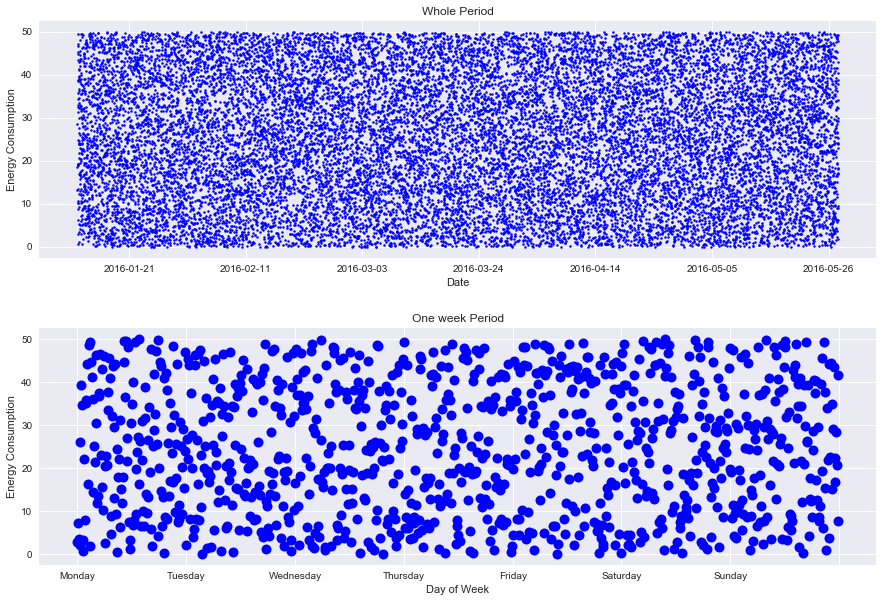

In [165]:
@interact
def energy_figure(df = df_m):#df1 = grouped_Energy, df2 = grouped_Energy_week):
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.3)

    ax0 = plt.subplot(gs[0,:])
    ax0.plot(df_m['date1'], df_m['Energy Consumption'], 'b.', markersize=5)
    ax0.set_title('Whole Period')
    ax0.set_xlabel('Date')
    ax0.set_ylabel('Energy Consumption')

    ax1 = plt.subplot(gs[1,:])
    ax1.plot(oneweek_df['date1'], oneweek_df['Energy Consumption'], 'b.', markersize=20)
    ax1.set_title('One week Period')
    ax1.set_xticklabels(list(grouped_Energy_week.day_of_week))
    ax1.set_xlabel('Day of Week')
    ax1.set_ylabel('Energy Consumption')

## 2.2.2 Heatmap

In [166]:
def week_heatmap(df, vmin, vmax):
    sns.set()
    # pivot
    grouped = df.groupby(['hour','Date'])['Energy Consumption'].sum()
    aa = grouped.reset_index()
    aa = aa.sort_values(by = ['hour', 'Date'])
    aa.hour = aa.hour.astype('int')
    z = aa.pivot("hour", "Date", "Energy Consumption").fillna(0)
    # figure
    f, ax = plt.subplots(figsize=(4, 10))
    cmap = plt.cm.autumn_r
    f = sns.heatmap(z, cmap=cmap, linewidths=0, vmin=vmin, vmax=vmax, cbar_kws={"shrink": .5})
    # format
    dow = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    ax.set_xticklabels(list(dow), rotation=0)
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Hour of Day')
    plt.yticks(rotation=0) 
    f.invert_yaxis()

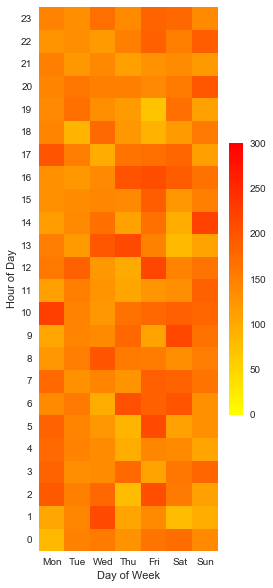

In [168]:
week_heatmap(oneweek_df, 0,300)#np.min(oneweek_df['Energy Consumption'], np.max(oneweek_df['Energy Consumption'])))

## 2.2.3 Histogram for Energy Consumption of Appliances

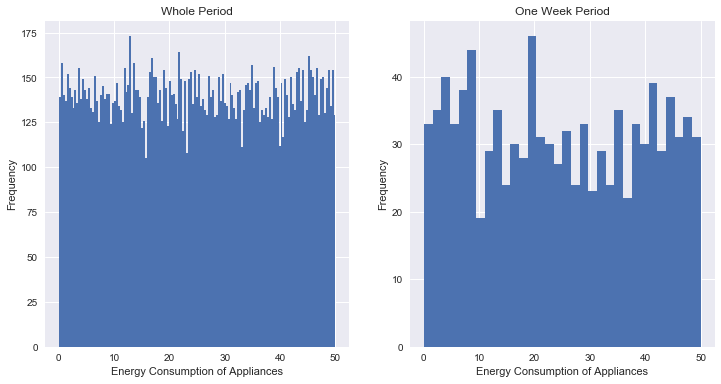

In [144]:
@interact
def hist_energy(df1 = df_m, df2 = oneweek_df):
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

    num_bins1 = math.ceil(math.pow(len(df_m['Energy Consumption']), 0.5))
    ax0 = plt.subplot(gs[0,0])
    ax0.hist(df_m['Energy Consumption'], bins=num_bins1)
    ax0.set_ylabel('Frequency')
    ax0.set_xlabel('Energy Consumption of Appliances')
    ax0.set_title('Whole Period')
    num_bins2 = math.ceil(math.pow(len(oneweek_df['Energy Consumption']), 0.5))
    ax1 = plt.subplot(gs[0,1])
    ax1.hist(oneweek_df['Energy Consumption'], bins=num_bins2)
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel('Energy Consumption of Appliances')
    ax1.set_title('One Week Period')

## 2.2.4 NSM vs. Energy Consumption

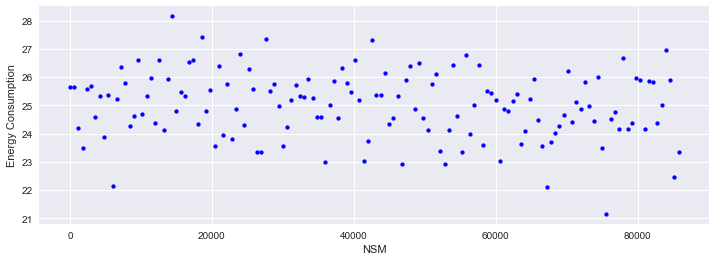

In [26]:
@interact
def NSM_EC(df = df_m):
    plt.figure(figsize=(12,4))
    
    df_m['NSM'] = df_m['hour']*3600 + df_m['min']*60
    NSM_group = df_m.groupby(['NSM'])['Energy Consumption'].mean()
    NSM_group = NSM_group.reset_index()
    NSM_group.NSM = NSM_group.NSM.astype('int')
    
    plt.scatter(NSM_group.NSM, NSM_group['Energy Consumption'], color = "b", label="fast", s=15)
    plt.xlabel("NSM")
    plt.ylabel("Energy Consumption")

## 2.2.5 Press mm Hg vs. Energy Consumption

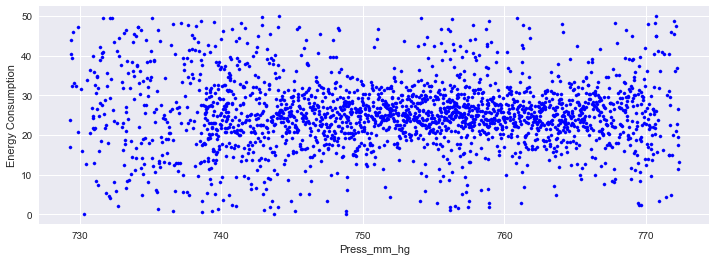

In [27]:
@interact
def press_mm_Hg(df = df_m):
    plt.figure(figsize=(12,4))
    
    press_group = df_m.groupby(['Press_mm_hg'])['Energy Consumption'].mean()
    press_group = press_group.reset_index()
    
    plt.scatter(press_group.Press_mm_hg, press_group['Energy Consumption'],color = "b", label="fast", s=10)
    plt.xlabel("Press_mm_hg")
    plt.ylabel("Energy Consumption")

## 2.2.6 Conclusion

###  NSM can be the representation for data time from morning to midnight. People will go to work or school from 9am to 5pm, so the energy consumption would be decreased. 

## 2.3.1

In [101]:
df_air = pd.read_csv(dirpath+'/Assignment_1/airfoil_self_noise.dat', sep='\s+', header=None)
df_air.columns=['Frequency', 'Angle_of_attack', 'Chord_length', 'Free_stream_velocity', 'thickness', 'pressure_level']

In [132]:
@interact
def stat_des(df = df_air):
    df_mean = pd.DataFrame(df_air.mean(axis=0))
    df_std  = pd.DataFrame(df_air.std(axis=0))
    df_skew = pd.DataFrame(df_air.skew(axis=0))
    df_kurt = pd.DataFrame(df_air.kurt(axis=0))
    df_madian = pd.DataFrame(df_air.median(axis=0))
    df_min  = pd.DataFrame(df_air.min(axis=0))
    df_max  = pd.DataFrame(df_air.max(axis=0))
    # Creating dataframe
    stat_summary = pd.concat([df_mean,df_std,df_skew,df_kurt,df_madian,df_min,df_max],axis=1)
    stat_summary.columns = ['Mean', 'sd', 'skew', 'Kurtosis','median', 'min','max']
    stat_summary['range'] = stat_summary['max'] - stat_summary['min']
    #stat_summary.transpose()
    return stat_summary

,Mean,sd,skew,Kurtosis,median,min,max,range
Frequency,2886.380572,3152.573137,2.137084,5.708685,1600.000000,200.000000,20000.000000,19800.000000
Angle_of_attack,6.782302,5.918128,0.689164,-0.412951,5.400000,0.000000,22.200000,22.200000
Chord_length,0.136548,0.093541,0.457457,-1.037964,0.101600,0.025400,0.304800,0.279400
Free_stream_velocity,50.860745,15.572784,0.235852,-1.563951,39.600000,31.700000,71.300000,39.600000
thickness,0.011140,0.013150,1.702165,2.218903,0.004957,0.000401,0.058411,0.058011
pressure_level,124.835943,6.898657,-0.418952,-0.314187,125.721000,103.380000,140.987000,37.607000
